<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Anna Tarelina (@feuerengel). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Assignment #3. Optional part
## <center> Implementation of the decision tree algorithm

This part is optional and not graded in mlcourse.ai. However, it's very helpful if you'd like to understand how decision trees work. Implementing (or at least describing) parts of tree-learning algorithms is a popular interview question as well :)  

In [1045]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import scipy

import seaborn as sns
sns.set()

Let's fix `random_state` (a.k.a. random seed) beforehand.

In [22]:
RANDOM_STATE = 17

**Implement the class `DecisionTree`**
**Specification:**
- the class is inherited from `sklearn.BaseEstimator`;
- class constructor has the following parameters: 
    `max_depth` - maximum depth of the tree (`numpy.inf` by default); 
    `min_samples_split` - the minimum number of instances in a node for a splitting to be done (2 by default); 
    `criterion` - split criterion ('gini' or 'entropy' for classification, 'variance' or 'mad_median' for regression; 'gini' by default);
    
    A functional to be maximized to find an optimal partition at a given node has the form
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    where $X$ are samples at a given node, $X_l$ and $X_r$ are partitions of samples $X$ into two parts 
    with the following condition $[x_j < t]$, and $F(X)$ is a partition criterion.
    
    For classification: let $p_i$ be the fraction of the instances of the $i$-th class in the dataset $X$.
    
    'gini': Gini impurity $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Entropy $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    For regression: $y_j = y(x_j)$ - is a target for an instance $x_j$, $y = (y_1, \dots, y_{|X|})$ - is a target vector.
    
    'variance': Variance (mean quadratic deviation from average) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Mean deviation from the median $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- the class has several methods: `fit`, `predict` and `predict_proba`;
- the`fit` method takes the matrix of instances `X` and a target vector `y` (`numpy.ndarray` objects) and returns an instance of the class `DecisionTree` representing the decision tree trained on the dataset `(X, y)` according to parameters set in the constructor; 
- the `predict_proba` method takes the matrix of instances `X` and returns the matrix `P` of a size `X.shape[0] x K`, where `K` is the number of classes and $p_{ij}$ is the probability of an instance in $i$-th row of `X` to belong to class $j \in \{1, \dots, K\}$.
- the `predict` method takes the matrix of instances `X` and returns a prediction vector; in case of classification, prediction for an instance $x_i$ falling into leaf $L$ will be the class, mostly represented among instances in $L$. In case of regression, it'll be the mean value of targets for all instances in leaf $L$.

In [11]:
def entropy(y):    
    y = y.astype(int)
    probs = np.bincount(y) / y.size
    probs = np.maximum(probs, np.full_like(probs, 1e-50))
    
    return - np.sum(probs * np.log2(probs))
    
def gini(y):
    y = y.astype(int)
    probs = np.bincount(y) / y.size
    probs = np.maximum(probs, np.full_like(probs, 1e-50))
    
    return 1 - np.sum(np.square(probs))

def variance(y):
    y_mean = y.mean()
    return np.sum(np.square(y-y.mean()))/y.size
    
def mad_median(y):
    y_median = np.median(y)
    return np.sum(np.abs(y-y_median))/y.size

In [3]:
import numpy as np

In [8]:
y = np.random.randint(0, 2, 50000)

In [1031]:
entropy(y), gini(y), variance(y), mad_median(y)

(3.3217753538402386, 0.8999789112442087, 8.205397049246425, 2.4885920979410128)

The `Node` class implements a node in the decision tree.

In [325]:
class Node():
    
    def __init__(self, feature_idx=None, threshold=None, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

Let's determine the function for calculating a prediction in a leaf. For regression, let's take the mean for all values in a leaf, for classification - the most popular class in leaf.

In [1101]:
class DecisionTree(BaseEstimator):
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, 
                 criterion='gini', debug=False):
      
        
        self.dic  = {
            "gini" : gini, 
            "entropy" : entropy, 
            "variance" : variance, 
            "mad_median" : mad_median
        }


        
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        
        self.n_iterations = 0
        self.tree_depth = 1 
        
        # we need to know n classes for predict proba
        self.n_classes = None
        
    def select_optimal_boost(self, X,y):
        ls = []
        information_gain = 0 
        threshold = None
        feature_idx = None
        starting_entropy = self.criterion(y)
        for feature in range(X.shape[1]):
            X_0 = X[:, feature ]
            # TODO: Leave only non zero ones.
            for threshold_candidate in np.sort(np.unique(X_0))[1:-1]:
                left = y[X_0>=threshold_candidate]
                right = y[X_0<threshold_candidate]
                
                ig = starting_entropy - left.size/X_0.size * self.criterion(left) - right.size/X_0.size * self.criterion(right)
                if ig> information_gain:
                    threshold = threshold_candidate
                    feature_idx = feature
                    information_gain= ig
        return information_gain, threshold, feature_idx

    def fit(self, X, y):

        self.criterion = self.dic[self.criterion]
        print(self.criterion)
        self.n_classes = np.unique(y).size
        self.build_tree(X, y)
        return self
    
    def build_tree(self, X, y, depth_=0):
        
        t = Node()
        
        self.n_iterations +=1
        
#         print(str(self.n_iterations) + '------------------- iteration' + str(depth_))
        
        if depth_ == self.max_depth:
            t.labels = y
            return  t
        
        information_gain, threshold, feature_idx = self.select_optimal_boost(X, y)
    
        if (information_gain < 1e-3) or (threshold is None) or (feature_idx is None):
            t.labels = y 
#             print('end of the tree')        
        else: 
            #slicing the tree to pass it to the next iteration
            X_left = X[X[:, feature_idx]<threshold]
            y_left = y[X[:, feature_idx]<threshold]
            X_right = X[X[:, feature_idx]>=threshold]
            y_right = y[X[:, feature_idx]>=threshold]
            
            if (y_left.size < self.min_samples_split) or (y_right.size < self.min_samples_split):
                t.labels = y
                return t
            
            t.threshold = threshold
            t.feature_idx = feature_idx
            t.left = self.build_tree(X_left, y_left, depth_+1)
            t.right = self.build_tree(X_right, y_right, depth_+1)
        
        self.fitted_tree = t
        return t
    
    def predict_label(self, X, t, is_label=1): 

        if (t.left is not None) and (t.right is not None):
            if X[t.feature_idx]>=t.threshold:
                result = self.predict_label(X, t.right, is_label)
            else:
                result = self.predict_label(X, t.left, is_label)
        elif is_label==1:
            if self.criterion in (gini, entropy):
                return scipy.stats.mode(t.labels).mode[0]
            else:
                return t.labels.mean()
        else:
            if self.criterion in (gini, entropy):
                arr_mask = np.bincount(t.labels)/t.labels.size
                return np.concatenate([arr_mask, np.zeros(self.n_classes-arr_mask.size)])
            else:
                raise ValueError('it is a regression. No probas')
            
        return result

    
    
    def predict(self, X):
        if self.fitted_tree is None:
            raise ValueError('The tree has not been fitted yet')
        ls = []
        for sample in X:
            label = self.predict_label(sample, self.fitted_tree,is_label=1)
            ls.append(label)
        return np.array(ls)
        
    def predict_proba(self, X):
        if self.fitted_tree is None:
            raise ValueError('The tree has not been fitted yet')
        ls = []
        for sample in X:
            label = self.predict_label(sample, self.fitted_tree, is_label=0)
            ls.append(label)
        return np.array(ls) 
    
#     def print_tree(t):
#         try:
#             print(t.labels.shape)
#         except:
#             pass
#         if t.left is not None:
#             print_tree(t.left)
#         if t.right is not None:
#             print_tree(t.right)
    

In [631]:
dt = DecisionTree(max_depth=500, min_samples_split=1)
tr = dt.fit(X, y)
y_pred = dt.predict(X)

1------------------- iteration1
2------------------- iteration2
3------------------- iteration3
4------------------- iteration4
5------------------- iteration5
6------------------- iteration6
end of the tree
7------------------- iteration6
8------------------- iteration7
end of the tree
9------------------- iteration7
10------------------- iteration8
end of the tree
11------------------- iteration8
end of the tree
12------------------- iteration5
end of the tree
13------------------- iteration4
14------------------- iteration5
end of the tree
15------------------- iteration5
16------------------- iteration6
end of the tree
17------------------- iteration6
end of the tree
18------------------- iteration3
19------------------- iteration4
20------------------- iteration5
21------------------- iteration6
end of the tree
22------------------- iteration6
end of the tree
23------------------- iteration5
24------------------- iteration6
end of the tree
25------------------- iteration6
end of t

213------------------- iteration7
214------------------- iteration8
215------------------- iteration9
216------------------- iteration10
end of the tree
217------------------- iteration10
218------------------- iteration11
219------------------- iteration12
end of the tree
220------------------- iteration12
end of the tree
221------------------- iteration11
end of the tree
222------------------- iteration9
223------------------- iteration10
end of the tree
224------------------- iteration10
end of the tree
225------------------- iteration8
226------------------- iteration9
227------------------- iteration10
end of the tree
228------------------- iteration10
end of the tree
229------------------- iteration9
230------------------- iteration10
end of the tree
231------------------- iteration10
232------------------- iteration11
end of the tree
233------------------- iteration11
234------------------- iteration12
end of the tree
235------------------- iteration12
236------------------- ite

## Testing the implemented algorithm

### Classification

Download the dataset `digits` using the method `load_digits`. Split the data into train and test with the `train_test_split` method, use parameter values `test_size=0.2`, and `random_state=17`. Try to train shallow decision trees and make sure that gini and entropy criteria return different results.

In [1102]:
X, y = load_digits(n_class=10)["data"], load_digits(n_class=10)["target"]

X_train,X_test, y_train, y_test =   train_test_split(X, y, test_size=0.2, random_state=17)

In [696]:
ls = []
for criterion in ('gini', 'entropy'):
    for max_depth in tqdm(range(2, 15)):
        dt = DecisionTree(max_depth=max_depth,
                          criterion=criterion)
        
        dt.fit(X_train, y_train)

        y_train_pred = dt.predict(X_train)
        acc_train  = accuracy_score(y_train, y_train_pred)

        y_test_pred = dt.predict(X_test)
        acc_test  = accuracy_score(y_test, y_test_pred)

        dic = {
            "criterion" : criterion, 
            "max_depth" : max_depth, 
            "acc_train" : acc_train, 
            "acc_test" : acc_test
        }
        ls.append(dic)
        


100%|██████████| 13/13 [00:16<00:00,  1.87s/it]


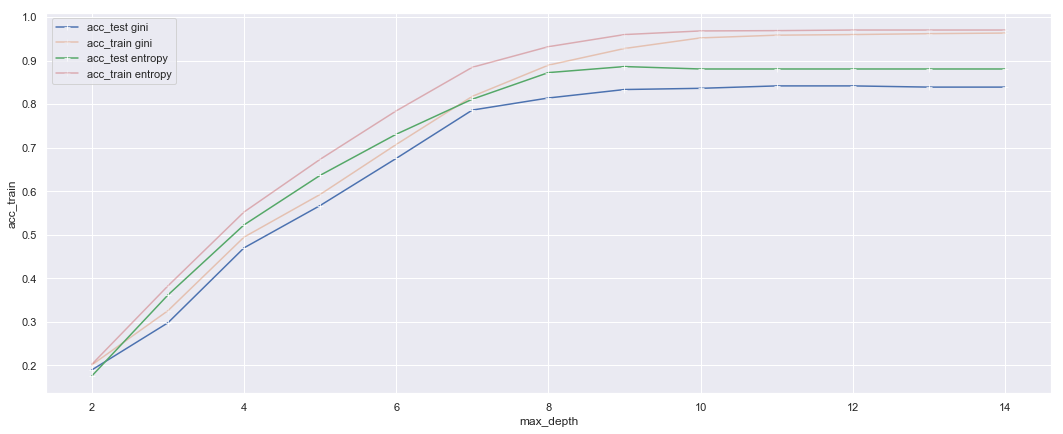

In [697]:
df = pd.DataFrame(ls)
plt.figure(figsize=(18,7))

for criterion in ('gini', 'entropy'):
    df1 = df[df.criterion==criterion]
    ax = sns.lineplot(df1['max_depth'], df1["acc_test"], label='acc_test {0}'.format(criterion), marker='+')        
    sns.lineplot(df1['max_depth'], df1["acc_train"], label='acc_train {0}'.format(criterion), marker='+', alpha=0.4)

    
plt.legend()

Using 5-folds cross-validation (`GridSearchCV`) pick up the optimal values of the `max_depth` and `criterion` parameters. For the parameter `max_depth` use range(3, 11), for criterion use {'gini', 'entropy'}. Quality measure is `scoring`='accuracy'.

In [1103]:
param_grid = {
    "max_depth" : range(3, 11), 
    "criterion" : ["gini", 'entropy']
}
gridSearch = GridSearchCV(DecisionTree(),param_grid, scoring='accuracy', verbose=2)
gridSearch.fit(X, y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] criterion=gini, max_depth=3 .....................................
<function gini at 0x1a32e10400>
[CV] ...................... criterion=gini, max_depth=3, total=   0.4s
[CV] criterion=gini, max_depth=3 .....................................
<function gini at 0x1a32e10400>


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ...................... criterion=gini, max_depth=3, total=   0.3s
[CV] criterion=gini, max_depth=3 .....................................
<function gini at 0x1a32e10400>
[CV] ...................... criterion=gini, max_depth=3, total=   0.3s
[CV] criterion=gini, max_depth=4 .....................................
<function gini at 0x1a32e10400>
[CV] ...................... criterion=gini, max_depth=4, total=   0.4s
[CV] criterion=gini, max_depth=4 .....................................
<function gini at 0x1a32e10400>
[CV] ...................... criterion=gini, max_depth=4, total=   0.4s
[CV] criterion=gini, max_depth=4 .....................................
<function gini at 0x1a32e10400>
[CV] ...................... criterion=gini, max_depth=4, total=   0.4s
[CV] criterion=gini, max_depth=5 .....................................
<function gini at 0x1a32e10400>
[CV] ...................... criterion=gini, max_depth=5, total=   0.6s
[CV] criterion=gini, max_depth=5 ..........................

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   43.0s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTree(criterion='gini', debug=None, max_depth=inf, min_samples_split=2),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(3, 11), 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [1105]:
gridSearch.best_params_, gridSearch.best_score_

({'criterion': 'gini', 'max_depth': 10}, 0.7807456872565387)

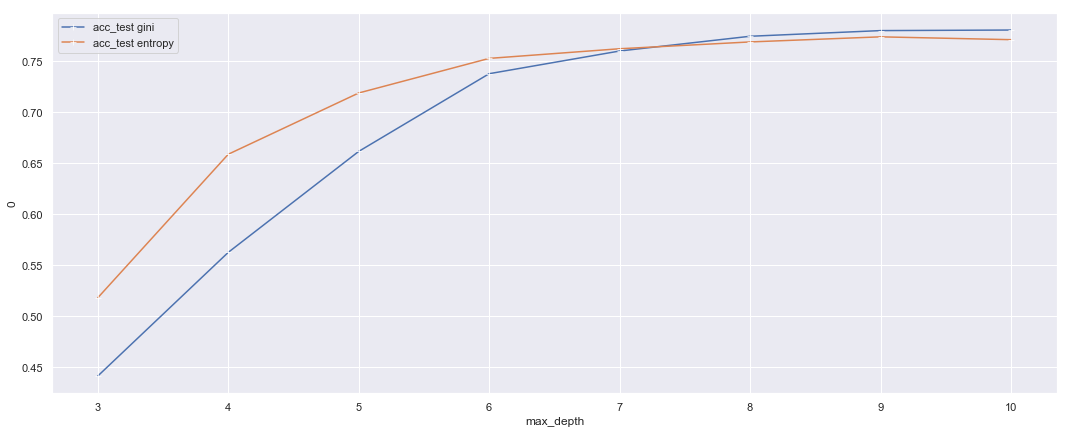

In [1106]:
indexes = pd.DataFrame(gridSearch.cv_results_["params"])
indexes = pd.concat([indexes, pd.Series(gridSearch.cv_results_["mean_test_score"])], axis=1)

plt.figure(figsize=(18,7))

for criterion in ('gini', 'entropy'):
    df1 = indexes[indexes.criterion==criterion]
    ax = sns.lineplot(df1['max_depth'], df1[0], label='acc_test {0}'.format(criterion), marker='+')        
plt.legend()

In [1108]:
indexes.sort_values(by=['criterion', 0], ascending=[False, False])

,criterion,max_depth,0
7,gini,10,0.780746
6,gini,9,0.780189
5,gini,8,0.774624
4,gini,7,0.760156
3,gini,6,0.737896
2,gini,5,0.661658
1,gini,4,0.562604
0,gini,3,0.441291
14,entropy,9,0.774068
15,entropy,10,0.771285


## just checking myself

**1. Choose all correct statements:**
1. Optimal value of the `max_depth` parameter is on the interval [4, 9] for both criteria.
2. Created plots have no intersection on the interval [3, 10]
3. **Created plots intersect each other only once on the interval [3, 10].**
4. **The best quality for `max_depth` on the interval [3, 10] is reached using `gini` criterion .**
5. **Accuracy is strictly increasing at least for one of the criteria, when `max_depth` is also increasing on the interval [3, 10]**

**2. What are the optimal values for max_depth and criterion parameters?**
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. **max_depth = 10, criterion = 'gini';**
5. max_depth = 9, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

Train decision tree on `(X_train, y_train)` using the optimal values of `max_depth` and `criterion`. Compute class probabilities for `X_test`.

In [1109]:
dt = DecisionTree(max_depth = 10, criterion='gini')
dt.fit(X_train, y_train)

<function gini at 0x1a32e10400>


DecisionTree(criterion=<function gini at 0x1a32e10400>, debug=None,
       max_depth=10, min_samples_split=2)

Using the given matrix, compute the mean class probabilities for all instances in `X_test`.

In [1110]:
probs = dt.predict_proba(X_test)

In [1111]:
probs.mean(axis=0).max()

0.12691798941798949

**3. What is the maximum probability in a resulted vector?**
1. **0.127**
2. 0.118
3. 1.0
4. 0.09

## Regression

Download the dataset `boston` using the method `load_boston`. Split the data into train and test with the `train_test_split` method, use parameter values `test_size=0.2`, `random_state=17`. Try to train shallow regression decision trees and make sure that `variance` and `mad_median` criteria return different results.

In [1112]:
X, y = load_boston()["data"], load_boston()["target"]

X_train,X_test, y_train, y_test =   train_test_split(X, y, test_size=0.2, random_state=17)

Using 5-folds cross-validation (`GridSearchCV`) pick up the optimal values of the `max_depth` and `criterion` parameters. For the parameter `max_depth` use `range(2, 9)`, for `criterion` use {'variance', 'mad_median'}. Quality measure is `scoring`='neg_mean_squared_error'.

In [1113]:
param_grid = {
    "max_depth" : range(2, 9), 
    "criterion" : ['variance', 'mad_median']
}
gridSearch = GridSearchCV(DecisionTree(),param_grid, scoring='neg_mean_squared_error', verbose=10)
gridSearch.fit(X, y)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV] criterion=variance, max_depth=2 .................................
<function variance at 0x1a32e10488>
[CV]  criterion=variance, max_depth=2, score=-19.411845387263018, total=   0.2s
[CV] criterion=variance, max_depth=2 .................................
<function variance at 0x1a32e10488>


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=variance, max_depth=2, score=-57.07363960849807, total=   0.2s
[CV] criterion=variance, max_depth=2 .................................
<function variance at 0x1a32e10488>
[CV]  criterion=variance, max_depth=2, score=-65.48714320670842, total=   0.2s
[CV] criterion=variance, max_depth=3 .................................
<function variance at 0x1a32e10488>


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV]  criterion=variance, max_depth=3, score=-27.517786810821914, total=   0.3s
[CV] criterion=variance, max_depth=3 .................................
<function variance at 0x1a32e10488>


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


[CV]  criterion=variance, max_depth=3, score=-57.40674922673394, total=   0.3s
[CV] criterion=variance, max_depth=3 .................................
<function variance at 0x1a32e10488>


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s


[CV]  criterion=variance, max_depth=3, score=-50.90654654279648, total=   0.3s
[CV] criterion=variance, max_depth=4 .................................
<function variance at 0x1a32e10488>


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.4s remaining:    0.0s


[CV]  criterion=variance, max_depth=4, score=-22.303775576713317, total=   0.4s
[CV] criterion=variance, max_depth=4 .................................
<function variance at 0x1a32e10488>


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.8s remaining:    0.0s


[CV]  criterion=variance, max_depth=4, score=-44.67772091033651, total=   0.3s
[CV] criterion=variance, max_depth=4 .................................
<function variance at 0x1a32e10488>


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.1s remaining:    0.0s


[CV]  criterion=variance, max_depth=4, score=-44.185660501039635, total=   0.4s
[CV] criterion=variance, max_depth=5 .................................
<function variance at 0x1a32e10488>


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.5s remaining:    0.0s


[CV]  criterion=variance, max_depth=5, score=-25.70312502577595, total=   0.4s
[CV] criterion=variance, max_depth=5 .................................
<function variance at 0x1a32e10488>
[CV]  criterion=variance, max_depth=5, score=-52.099560173928616, total=   0.4s
[CV] criterion=variance, max_depth=5 .................................
<function variance at 0x1a32e10488>
[CV]  criterion=variance, max_depth=5, score=-43.57824495647042, total=   0.5s
[CV] criterion=variance, max_depth=6 .................................
<function variance at 0x1a32e10488>
[CV]  criterion=variance, max_depth=6, score=-28.7376059410822, total=   0.5s
[CV] criterion=variance, max_depth=6 .................................
<function variance at 0x1a32e10488>
[CV]  criterion=variance, max_depth=6, score=-51.13029221045181, total=   0.5s
[CV] criterion=variance, max_depth=6 .................................
<function variance at 0x1a32e10488>
[CV]  criterion=variance, max_depth=6, score=-43.72189933008181, total

[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:   30.0s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTree(criterion='gini', debug=None, max_depth=inf, min_samples_split=2),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(2, 9), 'criterion': ['variance', 'mad_median']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=10)

In [1114]:
gridSearch.best_params_, gridSearch.best_score_

({'criterion': 'variance', 'max_depth': 4}, -37.04162820254166)

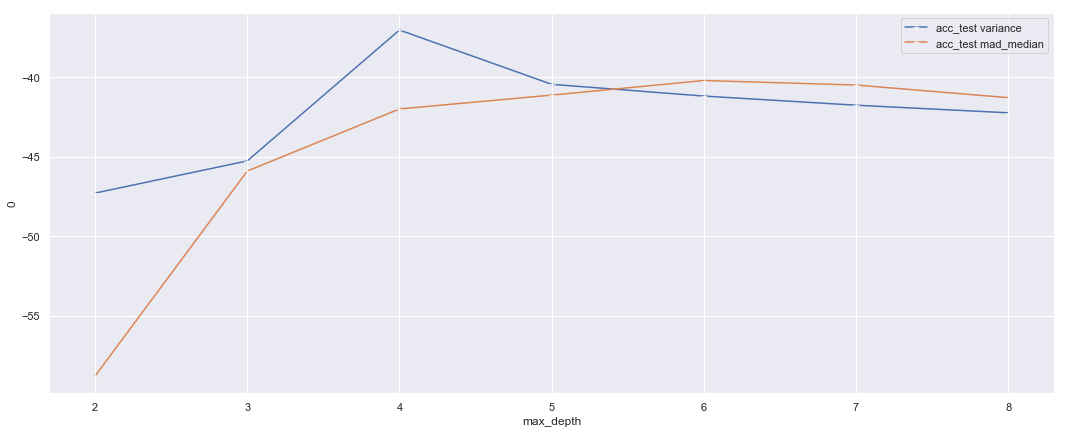

In [1115]:
indexes = pd.DataFrame(gridSearch.cv_results_["params"])
indexes = pd.concat([indexes, pd.Series(gridSearch.cv_results_["mean_test_score"])], axis=1)

plt.figure(figsize=(18,7))

for criterion in ('variance', 'mad_median'):
    df1 = indexes[indexes.criterion==criterion]
    ax = sns.lineplot(df1['max_depth'], df1[0], label='acc_test {0}'.format(criterion), marker='+')        
plt.legend()

**4. Choose all correct statements:**
1. Created plots have no intersection on the interval [2, 8].
2. **Created plots intersect each other only once on the interval [2, 8].**
3. Optimal value of the `max_depth` for each of the criteria is on the border of the interval [2, 8].
4. The best quality at `max_depth` on the interval [2, 8] is reached using `mad_median` criterion.

**5. What are the optimal values for `max_depth` and `criterion` parameters?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. **max_depth = 4, criterion = 'variance';**
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 5, criterion = 'variance'